In [855]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [856]:
import sys
sys.path.append('../../')

In [857]:
from regr.graph.concept import EnumConcept
from regr.graph import Graph, Concept, Relation
from regr.graph.logicalConstrain import ifL, nandL, orL, notL, andL, atMostL

digitRange = 10
summationRange = digitRange * 2 - 1

Graph.clear()
Concept.clear()
Relation.clear()

with Graph(name='global') as graph:
    image = Concept(name='image')
    
    digit = image(name='digit', ConceptClass=EnumConcept, values=list(map(lambda v: f'd_{v}', range(digitRange))))
    
    addition = Concept(name='addition')
    (operand1, operand2) = addition.has_a(operand1=image, operand2=image)
    
    summation = addition(name='summation', ConceptClass=EnumConcept, values=list(map(lambda v: f's_{v}', range(summationRange))))

    ifL(image,  atMostL(*digit.attributes))
    ifL(addition, atMostL(*summation.attributes))
    
    for i in range(digitRange):
        for j in range(i, digitRange):
            sumVal = i + j
            
            ifL(
                getattr(digit, f'd_{i}')('i'),
                ifL(
                    getattr(digit, f'd_{j}')('j', path=('i', operand1.reversed, operand2)),
                    getattr(summation, f's_{i+j}')('a', path=('j', operand2.reversed))
                ),
                active = True
            )


/Users/alexanderwan/miniconda3/envs/domiknows/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Please use OrderedDict rather than dict to prevent unpredictable order of arguments.For this instance, OrderedDict([('operand1', 'image'), ('operand2', 'image')]) is used.


In [858]:
import torch
from torch import nn

class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.recognition = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                    #   nn.LogSoftmax(dim=1)
                      )
    def forward(self, x):
        y = self.recognition(x)
        return y

In [859]:
def sum_func(d_1_distr, d_2_distr, prob_func = lambda d: F.softmax(d, dim=1)):
    # given d_1 and d_2 logits, get P(d_1) and P(d_2)
    # using P(d_1) and P(d_2), find P(d_1 + d_2)
    
    #print(d_1_distr.shape)
    
    #print(d_1_distr)
    
    Pd_1 = prob_func(d_1_distr)[0]
    Pd_2 = prob_func(d_2_distr)[0]
    
    #print(Pd_1, Pd_1.shape)
    
    Pd_sum = torch.zeros((summationRange,))
    
    for i in range(digitRange):
        for j in range(digitRange):
            Pd_sum[i + j] += Pd_1[i] * Pd_2[j]
    
    #print(Pd_sum.shape)
    
    return Pd_sum

In [860]:
input_size = 784
hidden_sizes = [128, 64]
epochs = 15
lr = 0.01

In [861]:
import torch.nn.functional as F

dummy_d1 = F.softmax(torch.rand((digitRange,)), dim=0)
dummy_d2 = F.softmax(torch.rand((digitRange,)), dim=0)

In [862]:
from regr.program.model.ilpu import ILPUModel
from regr.program.metric import MacroAverageTracker, PRF1Tracker, DatanodeCMMetric, MultiClassCMWithLogitsMetric
from regr.program.loss import NBCrossEntropyLoss

class Model(ILPUModel):
    def __init__(self, graph):
        super().__init__(
            graph,
            poi=(image, addition, summation),
            loss=MacroAverageTracker(NBCrossEntropyLoss()),
            metric={
                'ILP': PRF1Tracker(DatanodeCMMetric()),
                'argmax': PRF1Tracker(DatanodeCMMetric('local/argmax'))},
            inferTypes=['ILP', 'local/argmax'])

In [863]:
from regr.sensor.pytorch.sensors import FunctionalSensor, ReaderSensor, ConstantSensor, JointSensor
from regr.sensor.pytorch.learners import ModuleLearner
from regr.program import LearningBasedProgram
from regr.sensor.pytorch.relation_sensors import EdgeSensor

class ConstantEdgeSensor(ConstantSensor, EdgeSensor): pass

image['pixels'] = ReaderSensor(keyword='pixels')

addition[operand1.reversed] = ConstantEdgeSensor(image['pixels'], data=[[1,0]], relation=operand1.reversed)
addition[operand2.reversed] = ConstantEdgeSensor(image['pixels'], data=[[0,1]], relation=operand1.reversed)

image['logits'] = ModuleLearner('pixels', module=Net(input_size, hidden_sizes, digitRange))

image[digit] = FunctionalSensor('logits', forward=lambda x: x)

def test(x1, x2):
    print(x1.shape, x2.shape)
    
    return torch.zeros(summationRange)

addition[summation] = ReaderSensor(keyword='summation', label=True)
addition[summation] = FunctionalSensor(operand2.reversed('logits'), operand2.reversed('logits'), forward=sum_func)

program = LearningBasedProgram(graph, Model)

In [864]:
from data import get_readers

In [865]:
trainloader, validloader, testloader = get_readers()

In [876]:
from regr.program import POIProgram, IMLProgram, SolverPOIProgram
from regr.program.metric import ValueTracker

#program = LearningBasedProgram(graph, Model)

program = SolverPOIProgram(graph,
                            poi=(image, addition, summation),
                            inferTypes=['local/argmax'],
                            loss=MacroAverageTracker(NBCrossEntropyLoss()),
                            metric={'argmax':ValueTracker(DatanodeCMMetric('local/argmax'))
                                   }
                           )

In [877]:
from functools import partial

import logging
logging.basicConfig(level=logging.INFO)

program.train(trainloader,
              valid_set=validloader,
              test_set=testloader,
              train_epoch_num=1,
              Optim=partial(torch.optim.SGD,
                            lr=lr),
              device='auto')

INFO:regr.program.program:Epoch: 1
INFO:regr.program.program:Training:
Epoch 1 Training: 100%|██████████| 300/300 [00:05<00:00, 52.10it/s]
INFO:regr.program.program: - loss:
INFO:regr.program.program:{'summation': tensor(2.9291)}
INFO:regr.program.program: - metric:
INFO:regr.program.program: - - argmax
INFO:regr.program.program:{'summation': [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 

KeyboardInterrupt: 

In [870]:
node.getAttributes().keys()

dict_keys(['pixels', 'logits', '<digit>', '<digit>/local/softmax', '<digit>/local/argmax', '<digit>/ILP/x', '<digit>/ILP/xP', '<digit>/ILP'])

In [879]:
node.getRelationLinks()['addition'][0].getAttributes()

{'operand1.reversed': tensor([1, 0]),
 'operand2.reversed': tensor([0, 1]),
 '<summation>/label': 6}

In [892]:
for node in program.populate(validloader, device='auto'):
    node.inferILPResults()

    addition = node.getRelationLinks()['addition'][0]

    operands = addition.getRelationLinks()
    operand1 = operands['operand1'][0]
    operand2 = operands['operand2'][0]

    distr1 = operand1.getAttribute('<digit>/ILP')
    distr2 = operand2.getAttribute('<digit>/ILP')
    
    pred_digit_1 = torch.argmax(distr1)
    pred_digit_2 = torch.argmax(distr2)
    pred_sum = torch.argmax(sum_func(torch.unsqueeze(distr1, dim=0), torch.unsqueeze(distr2, dim=0)))
    
    print(pred_digit_1, pred_digit_2, pred_sum)
    
    break

dict_keys(['pixels', 'logits', '<digit>', '<digit>/local/softmax', '<digit>/local/argmax', '<digit>/ILP/x', '<digit>/ILP/xP', '<digit>/ILP'])
tensor(6) tensor(6) tensor(9)


In [567]:
import torch
from torch import nn
from torch.nn import functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.pool = nn.MaxPool2d(2, 2)

        self.lin1 = nn.Linear(256, 128)
        self.lin2 = nn.Linear(128, 10)
        
        self.relu = nn.ReLU()
        
        self.drop = nn.Dropout(p=0.5)
        
        self.sum_lin = nn.Linear(20, 19)

    def forward(self, x):
        x = torch.squeeze(x, dim=0)

        x = x.reshape(2, 1, 28, 28)

        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.reshape(2, -1)

        x = self.lin1(x)
        x = self.relu(x)
        
        x = self.drop(x)
        
        y_digit = self.lin2(x)
        
        return y_digit

In [569]:
class SumLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lin1 = nn.Linear(20, 64)
        self.lin2 = nn.Linear(64, 19)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = torch.unsqueeze(torch.flatten(x), dim=0)
        
        x = self.lin1(x)
        x = self.relu(x)
        
        y_sum = self.lin2(x)
        
        return y_sum

In [570]:
import random
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn import Flatten

import config

DATA_PATH = 'data'


def make_sum(samples):
    return {
        'pixels': torch.unsqueeze(torch.stack(tuple(map(lambda s: s[0], samples)), dim=0), dim=0),
        'summation': sum(map(lambda s: s[1], samples)),
        'digits': list(map(lambda s: s[1], samples))
    }


def get_readers():
    transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              Flatten(0)
                              ])
    trainset = datasets.MNIST(DATA_PATH, download=True, train=True, transform=transform)
    testset = datasets.MNIST(DATA_PATH, download=True, train=False, transform=transform)

    assert config.num_train * 2 <= 50000 and config.num_valid * 2 <= 10000 and config.num_test * 2 <= 10000

    trainloader = DataLoader(
        trainset,
        sampler=random.sample(range(0, 50000), config.num_train * 2),
        shuffle=False,
        batch_size=2,
        collate_fn=make_sum
        )
    validloader = DataLoader(
        trainset,
        sampler=random.sample(range(50000), config.num_valid * 2),
        shuffle=False,
        batch_size=2,
        collate_fn=make_sum
        )
    testloader = DataLoader(
        testset,
        sampler=random.sample(range(10000), config.num_test * 2),
        shuffle=False,
        batch_size=2,
        collate_fn=make_sum
        )

    return trainloader, validloader, testloader


In [571]:
trainloader, validloader, testloader = get_readers()

In [572]:
class SoftCrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        logprobs = F.log_softmax (input, dim = 1)
        return  -(target * logprobs).sum() / input.shape[0]

In [573]:
def avg(lst):
    return sum(lst)/len(lst)

In [574]:
p = torch.tensor([1/10] * 10)

joint = torch.zeros((10, 10, 19))
for i in range(10):
    for j in range(10):
        for s in range(19):
            if i + j == s:
                joint[i, j, s] = p[i] * p[j]

def get_digit_label(summation):
    # summation: label summation
    # digit, digit_idx: digit to get label for

    # P(d_0 = i and sum = s)
    margin = torch.sum(joint, dim=1)[:,summation]

    # P(sum = s)
    psum = torch.sum(torch.sum(joint, dim=0), dim=0)[summation]

    # P(d_0 = i | sum = 2)
    cond = margin/psum

    return torch.unsqueeze(cond, dim=0)

get_digit_label(18)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [578]:
from torch import optim
from torch.nn import BCEWithLogitsLoss, BCELoss
import itertools

net = Net()
sum_net = SumLayer()

opt_sum = optim.Adam(itertools.chain(net.parameters(), sum_net.parameters()), lr=0.001)

soft_loss = SoftCrossEntropyLoss()
hard_loss = nn.CrossEntropyLoss()

In [586]:
from sklearn.metrics import accuracy_score, classification_report

digit_pred_a = []
sum_pred_a = []

digit_label_a = []
sum_label_a = []

loss_digit_a = []
loss_sum_a = []

net.train()
sum_net.train()

for d in trainloader:
    opt_sum.zero_grad()
    
    x = d['pixels']
    
    digit_logits = net(x)
    digit_pred = F.softmax(digit_logits, dim=1)
    
    sum_logits = sum_net(digit_pred)
    sum_pred = F.softmax(sum_logits, dim=1)
    
    digit0_weak = get_digit_label(d['summation'])
    digit1_weak = get_digit_label(d['summation'])
    digit_label_weak = torch.cat([digit0_weak, digit1_weak], dim=0)
    
    #l_digit = soft_loss(digit_logits, digit_label_weak)
    #l_sum = hard_loss(sum_logits, torch.tensor([d['summation']]))
    
    l_digit = hard_loss(digit_logits, torch.tensor(d['digits']))
    
    l_total = l_digit
    
    l_total.backward()

    opt_sum.step()
    
    #print(l_digit.item(), torch.argmax(digit_pred, dim=1), torch.tensor(d['digits']))
    #print(l_sum.item(), torch.argmax(sum_pred), torch.tensor([d['summation']]))
    
    digit_pred_a.extend(torch.argmax(digit_pred, dim=1).tolist())
    digit_label_a.extend(d['digits'])
    
    sum_pred_a.append(torch.argmax(sum_pred).item())
    sum_label_a.append(d['summation'])
    
    loss_digit_a.append(l_digit.item())
    loss_sum_a.append(l_sum.item())

print("DIGITS:")
print(classification_report(digit_label_a, digit_pred_a))
print(avg(loss_digit_a), "\n")

print("SUM:")
print(classification_report(sum_label_a, sum_pred_a))
print(avg(loss_sum_a))

DIGITS:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       199
           1       0.96      0.97      0.97       197
           2       0.94      0.95      0.94       204
           3       0.89      0.87      0.88       185
           4       0.94      0.94      0.94       208
           5       0.89      0.89      0.89       195
           6       0.94      0.95      0.94       224
           7       0.94      0.91      0.92       206
           8       0.86      0.87      0.86       186
           9       0.89      0.89      0.89       196

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

0.24602575462474147 

SUM:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.26      1.00      0.41        23
           2       0.00      0.00      0.00

/Users/alexanderwan/miniconda3/envs/domiknows/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexanderwan/miniconda3/envs/domiknows/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexanderwan/miniconda3/envs/domiknows/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [641]:
digit0 = torch.arange(10).type(torch.float32)
digit1 = torch.arange(10).type(torch.float32)

digit0 = torch.unsqueeze(digit0, dim=1)
digit1 = torch.unsqueeze(digit1, dim=0)
d = torch.matmul(digit0, digit1)

print(d)

for i in range(-9, 9 + 1):
    print(torch.sum(torch.diagonal(torch.flip(d, dims=(0,)), offset=i)))

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.],
        [ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27.],
        [ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36.],
        [ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.],
        [ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54.],
        [ 0.,  7., 14., 21., 28., 35., 42., 49., 56., 63.],
        [ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72.],
        [ 0.,  9., 18., 27., 36., 45., 54., 63., 72., 81.]])
tensor(0.)
tensor(0.)
tensor(1.)
tensor(4.)
tensor(10.)
tensor(20.)
tensor(35.)
tensor(56.)
tensor(84.)
tensor(120.)
tensor(165.)
tensor(200.)
tensor(224.)
tensor(236.)
tensor(235.)
tensor(220.)
tensor(190.)
tensor(144.)
tensor(81.)


In [648]:
digit0 = torch.tensor([1/10] * 10)
digit1 = torch.tensor([1/10] * 10)

digit0 = torch.unsqueeze(digit0, dim=1)
digit1 = torch.unsqueeze(digit1, dim=0)
d = torch.matmul(digit0, digit1)
d = d.repeat(1, 1, 1, 1)
f = torch.flip(torch.eye(10), dims=(0,)).repeat(1, 1, 1, 1)
conv_diag_sums = F.conv2d(d, f, padding=(9,0), groups=1)[..., 0]

conv_diag_sums.shape

torch.Size([1, 1, 19])

In [645]:
torch.sum(conv_diag_sums)

tensor(1.)

In [3]:
import random
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn import Flatten

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              Flatten(0)
                              ])
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)

In [9]:
train_ids = random.sample(range(0, 50000), 10000 * 2)

In [39]:
from torch.utils.data import DataLoader, Dataset
import random

class SumBalanceDataset(Dataset):
    def __init__(self, dataset, digit_ids):
        digit_to_id = {}
        
        for d in range(10):
            digit_to_id[d] = []
        
        for d_id in digit_ids:
            digit_to_id[dataset[d_id][1]].append(d_id)
        
        self.num_train = len(digit_ids) // 2
        self.digit_to_id = digit_to_id
        self.dataset = dataset
        
        self.digit_id_pairs = self.build_balanced_sum()
    
    def build_balanced_sum(self):
        digit_id_pairs = []
        
        for i in range(self.num_train):
            s = random.randint(0, 18)
            d0, d1 = self.sample_digits_from_sum(s)
            
            d0_id = random.sample(self.digit_to_id[d0], 1)[0]
            d1_id = random.sample(self.digit_to_id[d1], 1)[0]
            
            digit_id_pairs.append((d0_id, d1_id, d0, d1))
        
        return digit_id_pairs

    def sample_digits_from_sum(self, sum_val):
        d0 = random.randint(max(0, sum_val - 9), min(sum_val, 9))
        d1 = sum_val - d0
        return (d0, d1)

    def __len__(self):
        return self.num_train
    
    def __getitem__(self, idx):
        d0_id, d1_id, d0, d1 = self.digit_id_pairs[idx]
        
        d0_image = self.dataset[d0_id]
        d1_image = self.dataset[d1_id]
        
        return {
            'pixels': torch.unsqueeze(torch.stack((d0_image[0], d1_image[0]), dim=0), dim=0),
            'summation': [d0 + d1],
            'digit0': [d0],
            'digit1': [d1]
        }

train_balanced = SumBalanceDataset(trainset, train_ids)

trainloader = DataLoader(
    train_balanced,
    shuffle=False
)

In [29]:
from matplotlib import pyplot as plt

digits = []
summations = []

for image in ds:
    digits.append(image['digit0'][0])
    digits.append(image['digit1'][0])
    summations.append(image['summation'][0])

(array([3113., 2128., 1702., 1492., 1502., 1475., 1597., 1760., 2137.,
        3094.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

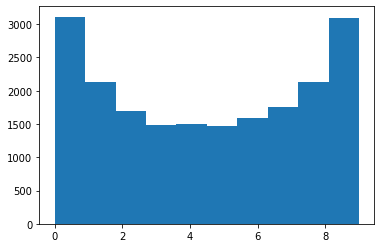

In [30]:
plt.hist(digits)

(array([531., 553., 520., 533., 509., 504., 515., 517., 506., 498., 553.,
        526., 550., 556., 534., 486., 549., 526., 534.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <BarContainer object of 19 artists>)

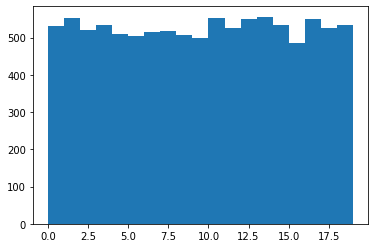

In [38]:
plt.hist(summations, bins=range(20))